# XDMoD Data Analytics Framework — First Example for JupyterHub

Notebook v1.1.0 (2025-07-14)

Compatible with XDMoD Data Analytics Framework v≥1.0.0 and <2.0.0

© 2023–2024 University at Buffalo Center for Computational Research

See the [xdmod-notebooks](https://github.com/ubccr/xdmod-notebooks) repository for information on setup, support, contributing, licensing, and referencing.

## Introduction

The XDMoD Data Analytics Framework provides API access to the data in XDMoD via the [`xdmod_data` Python module](https://pypi.org/project/xdmod-data). This notebook provides an introductory example showing how to use the module. You will use the XDMoD API to request data, load them into a [Pandas](https://pandas.pydata.org/) [DataFrame](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html), and generate plots. The dataset in this example contains the number of active users of [ACCESS](https://access-ci.org/)-allocated resources per day of the week over a 4-month period.

## Configure notebook formatting

### Exceptions

Run the code below to simplify how Python exceptions are displayed in this notebook.

In [ ]:
import sys
def exception_handler(exception_type, exception, traceback):
    print("%s: %s" % (exception_type.__name__, exception), file=sys.stderr)
get_ipython()._showtraceback = exception_handler

### Tables

Run the code below to set up for displaying Pandas DataFrames as Markdown tables in this notebook.

In [ ]:
from IPython.display import display, Markdown
def display_df_md_table(df):
    return display(Markdown(df.replace('\n', '<br/>', regex=True).to_markdown()))

### Plots

Run the code below to set up the external Plotly library to make plots using a custom XDMoD theme.

In [ ]:
import plotly.express as px
import plotly.io as pio
import xdmod_data.themes
pio.templates.default = "timeseries"

## Initialize the XDMoD Data Warehouse

Run the code below to prepare for getting data from the XDMoD data warehouse at the given URL. If no host is specified, the XDMOD_HOST environment variable is used to determine the host.

In [ ]:
from xdmod_data.warehouse import DataWarehouse
dw = DataWarehouse()

## Get the data

Run the code below to use the `get_data()` method to request data from XDMoD and load them into a Pandas DataFrame. This example gets the number of active users of ACCESS-allocated resources over a 4-month period. Each of the parameters of the method will be explained later in this notebook. Use `with` to create a runtime context; this is also explained later in this notebook.

In [ ]:
with dw:
    data = dw.get_data(
        duration=('2023-01-01', '2023-04-30'),
        realm='Jobs',
        metric='Number of Users: Active',
    )
display(data)

Note that the `data` object is a Pandas DataFrame:

In [ ]:
type(data)

## Plot the data

In [ ]:
plot = px.line(data, y='Number of Users: Active')
plot.show()

## Do further data processing

You can do further processing on the DataFrame to produce analysis and plots beyond those that are available in the XDMoD portal.

Run the code below to add a column for the day of the week:

In [ ]:
data['Day Name'] = data.index.strftime('%a')
display(data)

Run the code below to show a box plot of the data grouped by day of the week:

In [ ]:
plot = px.box(
    data,
    x='Day Name',
    y='Number of Users: Active',
    category_orders={'Day Name': ('Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat')},
)
plot.show()

## Details of the `get_data()` method

Now that you have seen a basic example of using the `get_data()` method, read below for more details on how it works.

### Wrap data warehouse calls in a runtime context

XDMoD data is accessed over a network connection, which involves establishing connections and creating temporary resources. To ensure these connections and resources are cleaned up properly in spite of any runtime errors, you should call data warehouse methods within a **runtime context** by using Python's `with` statement to wrap the execution of XDMoD queries, store the result, and execute any long running calculations outside of the runtime context, as in the template below.

In [ ]:
with dw:
    # XDMoD queries would go here
    pass
# Data processing would go here
pass

### Default parameters

The `get_data()` method has a number of parameters; their default values are shown below, and the parameters are explained in more detail further below.

In [ ]:
with dw:
    data = dw.get_data(
        duration='Previous month',
        realm='Jobs',
        metric='CPU Hours: Total',
        dimension='None',
        filters={},
        dataset_type='timeseries',
        aggregation_unit='Auto',
    )

### Duration

The **duration** provides the time constraints of the data to be fetched from the XDMoD data warehouse.

As already seen, you can specify the duration as start and end times:

In [ ]:
with dw:
    data = dw.get_data(duration=('2023-01-01', '2023-04-30'))

You can instead specify the duration using a special string value; a list of the valid values can be obtained by calling the `get_durations()` method.

In [ ]:
with dw:
    durations = dw.get_durations()
display(durations)

### Realm

A **realm** is a category of data in the XDMoD data warehouse. You can use the `describe_realms()` method to get a DataFrame containing the list of available realms.

In [ ]:
with dw:
    realms = dw.describe_realms()
display_df_md_table(realms)

### Metric

A **metric** is a statistic for which data exists in a given realm. You can use the `describe_metrics(realm)` method to get a DataFrame containing the list of valid metrics in the given realm. The realm must be passed in as a string.

In [ ]:
with dw:
    metrics = dw.describe_metrics('Jobs')
display_df_md_table(metrics)

### Dimension

A **dimension** is a grouping of data. You can use the `describe_dimensions(realm)` method to get a DataFrame containing the list of valid dimensions in the given realm. The realm must be passed in as a string.

In [ ]:
with dw:
    dimensions = dw.describe_dimensions('Jobs')
display_df_md_table(dimensions)

The code below shows how to get data grouped by the `Resource` dimension and plot them.

In [ ]:
metric_label = 'Number of Users: Active'
with dw:
    data = dw.get_data(
        duration=('2023-01-01', '2023-04-30'),
        realm='Jobs',
        metric=metric_label,
        dimension='Resource',
    )
plot = px.line(data, labels={'value': metric_label})
plot.show()

### Pass in realms, metrics, and dimensions using labels or IDs

For methods in the API that take realms, metrics, and/or dimensions as arguments, you can pass them in as their labels or their IDs.

In [ ]:
with dw:
    data = dw.get_data(
        duration='10 year',
        realm='Allocations',
        metric='NUs: Allocated', # 'allocated_nu' also works
        dimension='Resource Type',  # 'resource_type' also works
    )

### Filters

**Filters** allow you to include only data that have certain values for given dimensions. You can use the `get_filter_values(realm, dimension)` method to get a DataFrame containing the list of valid filter values for the given dimension in the given realm. The realm and dimension must be passed in as strings.

In [ ]:
with dw:
    filter_values = dw.get_filter_values('Jobs', 'Resource') # 'resource' also works
display_df_md_table(filter_values)

For methods in the API that take filters as arguments, you must specify the filters as a dictionary in which the keys are dimensions (labels or IDs) and the values are string filter values (labels or IDs) or sequences of string filter values. For example, to return only data for which the field of science is biophysics and the resource is either NCSA Delta GPU or TACC Stampede2:

In [ ]:
with dw:
    data = dw.get_data(
        filters={
            'Field of Science': 'Biophysics', # 'fieldofscience': '246' also works
            'Resource': ( # 'resource' also works
                'NCSA DELTA GPU', # '3032' also works
                'STAMPEDE2 TACC', # '2825' also works
            ),
        },
    )

### Dataset Type

The **dataset type** can either be 'timeseries' (the default), in which data is grouped by a time [aggregation unit](#Aggregation-unit), or 'aggregate', in which the data is aggregated across the entire [duration](#Duration). For 'aggregate', the results are returned as a Pandas Series rather than a DataFrame.

The code below shows how to create a bar plot of data aggregated over four months, grouped by resource.

In [ ]:
metric_label = 'Number of Users: Active'
with dw:
    data = dw.get_data(
        duration=('2023-01-01', '2023-04-30'),
        realm='Jobs',
        metric=metric_label,
        dimension='Resource',
        dataset_type='aggregate',
    )
plot = px.bar(data, labels={'value': metric_label})
plot.update_layout(
    showlegend=False,
    xaxis_automargin=True,
)
plot.show()

### Aggregation unit

The **aggregation unit** specifies how data is aggregated by time. You can get a list of valid aggregation units by calling the `get_aggregation_units()` method.

In [ ]:
with dw:
    display(dw.get_aggregation_units())

## Additional Examples

For additional examples, please see the [xdmod-notebooks repository](https://github.com/ubccr/xdmod-notebooks).

---
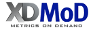 XDMoD Data Analytics Framework